**Part 1 : Miscellaneous**

In [69]:
#Environment details
import platform
import sys

# Python version
python_version = platform.python_version()

# Operating system
os_name = platform.system()
os_version = platform.version()

# Computer details
machine = platform.machine()

# Display information
print(f"Python Version: {python_version}")
print(f"Operating System: {os_name} {os_version}")
print(f"Machine: {machine}")


Python Version: 3.11.5
Operating System: Windows 10.0.22631
Machine: AMD64


In [70]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import emoji
import random
import string
from nltk.corpus import stopwords
import nltk
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from textblob import TextBlob
import itertools
from collections import defaultdict
from transformers import AutoTokenizer, AutoModel
from transformers import BertweetTokenizer, RobertaModel
import torch
from transformers import RobertaConfig
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

**Part 2 : Loading Dataset**

In [71]:
path = os.getcwd()
dataset_path = path + '/dataset'
dfs = []
for i,fname in enumerate(os.listdir(dataset_path)):
    if fname.endswith('.xlsx'):
        file_path = os.path.join(dataset_path, fname)
        df = pd.read_excel(file_path)
        dfs.append(df)
df = pd.concat(dfs,ignore_index=True)
df.head()

,question,reply,replies_count,up_counts,relevance_score,relevance_rating
0,What products/gadgets have you bought that hav...,Noise cancelling headphones and earbuds.,26,1270,NaN,NaN
1,What products/gadgets have you bought that hav...,Motion sensor rechargeable night lights for th...,13,657,NaN,NaN
2,What products/gadgets have you bought that hav...,A CPAP machine. Fixed 10yrs of very poor sleep...,14,351,NaN,NaN
3,What products/gadgets have you bought that hav...,Great big long phone charger cable. Rediscover...,4,169,NaN,NaN
4,What products/gadgets have you bought that hav...,"Electric blanket. My feet get cold, and withou...",8,436,NaN,NaN


In [72]:
df.shape

(15266, 6)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15266 entries, 0 to 15265
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          15266 non-null  object 
 1   reply             15265 non-null  object 
 2   replies_count     15266 non-null  int64  
 3   up_counts         15266 non-null  int64  
 4   relevance_score   0 non-null      float64
 5   relevance_rating  3436 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 715.7+ KB


**Part 3 : Preprocessing (basic and NLP)**

In [74]:
#Renaming column names
df.rename(columns={'reply': 'comment'}, inplace=True)
df.rename(columns={'up_counts': 'score'}, inplace=True)

In [75]:
#Dropping the records with no reply.
df = df.dropna(subset=['comment'])

In [76]:
#Dropping duplicate records.
df.drop_duplicates(subset=['question', 'comment'], keep='first', inplace=True)

In [77]:
#Dropping the records which are deleted/removed posts.
invalid_posts = ['[deleted]','[removed]']
df = df[~df['comment'].isin(invalid_posts)]

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14645 entries, 0 to 15265
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          14645 non-null  object 
 1   comment           14645 non-null  object 
 2   replies_count     14645 non-null  int64  
 3   score             14645 non-null  int64  
 4   relevance_score   0 non-null      float64
 5   relevance_rating  3291 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 800.9+ KB


In [79]:
df.describe()

,replies_count,score,relevance_score,relevance_rating
count,14645.000000,14645.000000,0.0,3291.000000
mean,0.472926,10.241584,NaN,5.735947
std,1.848217,67.832357,NaN,2.894158
min,0.000000,-87.000000,NaN,0.000000
25%,0.000000,1.000000,NaN,3.000000
50%,0.000000,1.000000,NaN,6.000000
75%,0.000000,3.000000,NaN,8.000000
max,90.000000,3466.000000,NaN,10.000000


In [80]:
#Cleaning the comment data.
def clean_text(text):
    #Removing the attached urls
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', text)
    
    #Replacing the \n with spaces
    text = text.replace('\n', ' ')
    
    #Removing the extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    #Removing the emojis
    text = emoji.demojize(text)
    
    return text
df['comment'] = df['comment'].apply(clean_text)

In [81]:
nltk.download('stopwords')
stop = stopwords.words('english')

def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    clean_text = re.sub(pattern, '', text)    
    return clean_text
    
#Not using this for now!
def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop])

df['comment'] = df['comment'].apply(remove_special_characters).str.lower()
df['question'] = df['question'].apply(remove_special_characters).str.lower()
df.head()

[nltk_data] Downloading package stopwords to C:\Users\Vineetha
[nltk_data]     Maddikunta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,question,comment,replies_count,score,relevance_score,relevance_rating
0,what productsgadgets have you bought that have...,noise cancelling headphones and earbuds,26,1270,NaN,NaN
1,what productsgadgets have you bought that have...,motion sensor rechargeable night lights for th...,13,657,NaN,NaN
2,what productsgadgets have you bought that have...,a cpap machine fixed 10yrs of very poor sleep ...,14,351,NaN,NaN
3,what productsgadgets have you bought that have...,great big long phone charger cable rediscover ...,4,169,NaN,NaN
4,what productsgadgets have you bought that have...,electric blanket my feet get cold and without ...,8,436,NaN,NaN


In [82]:
#Shuffling the records.
df = df.sample(frac=1).reset_index(drop=True)

In [83]:
df['question'].value_counts()

question
whats a food you went your whole life thinking it was nasty until you tried it                   3375
what is a pokemon you love that isnt very popular or talked about                                2491
what is your favourite game of all time                                                          1251
what are some terms in 90s that are no longer used today                                         1216
what do you all actually use chatgpt for                                                         1216
what productsgadgets have you bought that have made your livesmental health infinitely better    1175
at what age did you buy your first cool sports car and do you regret now                         1156
whats the worst thing about living alone                                                          979
what do yall think is the best iphone 15 pro max color                                            898
which cities in america is baseball more popular than football           

**Part 4 : Constructing a custom metric to calculate relevance**

In [145]:
def calculate_sentiment_probabilities(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity
    
def calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings):
    return cosine_similarity(question_embedding,cluster_comment_embeddings)
    
def calculate_cluster_coherence_tfidf(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    cluster_comment_embeddings_arr = np.array([comment[0] for comment in cluster_comment_embeddings])
    print(cluster_comment_embeddings_arr)
    print(cluster_comment_embeddings_arr.shape)
    if len(cluster_comment_embeddings_arr.shape) > 2:
        cluster_comment_embeddings_arr = cluster_comment_embeddings_arr.reshape(cluster_comment_embeddings_arr.shape[0], -1)
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings_arr)
    coherence = np.mean(pairwise_similarity)
    similarity = calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings_arr)
    return (coherence,similarity)
    
def calculate_cluster_coherence_lda(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    cluster_comment_embeddings_arr = np.array(cluster_comment_embeddings)
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings_arr)
    coherence = np.mean(pairwise_similarity)
    similarity = calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings_arr)
    return (coherence,similarity)
    
def calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings):
    return cosine_similarity([question_embedding],cluster_comment_embeddings)[0]

def calculate_cluster_coherence_pre_trained(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings)
    coherence = np.mean(list(itertools.chain.from_iterable(pairwise_similarity)))
    similarity = calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings)
    return (coherence,similarity)

#Custom Relevance metric
def calculate_relevance_scores(df, question_embedding,cluster_embeddings, topics, mode):
    relevance_scores = []
    
    for key,cluster_comments in topics.items():
        # Extracting the comments in this cluster
        df_temp = df[df['comment'].isin(cluster_comments)]
        relevance_score = 0
        
        #Check for empty clusters
        if len(df_temp) != 0 :            
            #1. User engagement factors: score and reply counts
            max_score = max(df_temp['score'])
            min_score = min(df_temp['score'])
            mean_score = 0
            if max_score == min_score :
                mean_score = max_score
            else:
                normalized_scores = [(s - min_score) / (max_score - min_score) for s in df_temp['score']]
                mean_score = np.mean(normalized_scores)
            
            
            max_replies = max(df_temp['replies_count'])
            min_replies = min(df_temp['replies_count'])
            mean_reply_count = 0
            if max_replies == min_replies:
                mean_reply_count = max_replies
            else:
                normalized_replies = [(count - min_replies) / (max_replies - min_replies) for count in df_temp['replies_count']]
                mean_reply_count = np.mean(normalized_replies)
            
            #2. Cluster coherence
            #3. Semantic similarity
            coherence,semantic_similarity = eval('calculate_cluster_coherence_' + mode)(question_embedding,cluster_embeddings,key)
            
            #4. Sentiment polarity of each comment
            sentiments = [calculate_sentiment_probabilities(comment) for comment in cluster_comments]
            max_sentiment = max(sentiments)
            min_sentiment = min(sentiments)
            mean_sentiment = 0
            if max_sentiment == min_sentiment:
                mean_sentiment = max_sentiment
            else:
                normalized_sentiment = [(sentiment - min_sentiment) / (max_sentiment - min_sentiment) for sentiment in sentiments]
                mean_sentiment = np.mean(normalized_sentiment)
    
            # Calculate relevance score for the current cluster
            relevance_score = mean_score + (0.25*mean_reply_count) + mean_sentiment + np.mean(semantic_similarity) + coherence   
            
        relevance_scores.append((str(key),relevance_score))
        
    relevances = [r for _, r in relevance_scores]    
    # max_relevance = max(relevances)
    # min_relevance = min(relevances)
    # normalized_relevances = [(relevance - min_relevance) / (max_relevance - min_relevance) for relevance in relevances]
    
    # Create a dictionary with comments as keys and normalized relevance scores as values
    relevance_scores = dict(zip(topics.keys(), relevances))
    return relevance_scores

**Part 5 : Embeddings**

In [85]:
question1df = df[df['question'] == df['question'][0]]

question = question1df['question'][0]
comments = question1df['comment'].to_numpy(dtype='object')

- **Hybrid Model - LDA + Bert**

In [86]:
# Vectorize the corpus using TF-IDF
vectorizer2 = TfidfVectorizer()
X = vectorizer2.fit_transform([question] + comments)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
lda_model.fit(X)

# Transform question and comments to topic distributions
question_topic = lda_model.transform(vectorizer2.transform([question]))
comment_topics = lda_model.transform(vectorizer2.transform(comments))

In [87]:
#Bert 
model = SentenceTransformer('paraphrase-distilroberta-base-v2')
comment_embeddings = model.encode(comments)
question_embedding = model.encode(question)

In [88]:
combined_embeddings1 = np.concatenate((comment_topics, comment_embeddings), axis=1)
question_embedding_reshaped = question_embedding.reshape(1, -1)
question_combined1 = np.concatenate((question_topic, question_embedding_reshaped), axis=1)

- **Hybrid Model - LDA + Bert Quora**

In [89]:
#Bert - Quora
model2 = SentenceTransformer('quora-distilbert-multilingual', device='cpu') 
comment_embeddings_m2 = model2.encode(comments)
question_embedding_m2 = model2.encode(question)

In [90]:
combined_embeddings2 = np.concatenate((comment_topics, comment_embeddings_m2), axis=1)
question_embedding_reshaped2 = question_embedding_m2.reshape(1, -1)
question_combined2 = np.concatenate((question_topic, question_embedding_reshaped2), axis=1)

- **Hybrid Model - LDA + MiniLM**

In [92]:
model3 = SentenceTransformer('all-MiniLM-L6-v2', device='cpu') 
comment_embeddings_m3 = model3.encode(comments)
question_embedding_m3 = model3.encode(question)

In [93]:
combined_embeddings3 = np.concatenate((comment_topics, comment_embeddings_m3), axis=1)
question_embedding_reshaped3 = question_embedding_m3.reshape(1, -1)
question_combined3 = np.concatenate((question_topic, question_embedding_reshaped3), axis=1)

**Part 6 : Model Building**

In [94]:
#Decides the clusters count and therefore the rating scale (which is 1-5)
num_topics = 5

- KMeans clustering model for LDA + Bert

In [95]:
kmeans_hybrid1 = KMeans(n_clusters=num_topics)
kmeans_hybrid1.fit(combined_embeddings1)

# Assign each comment to a cluster
cluster_labels_hybrid1 = kmeans_hybrid1.labels_

cluster_embeddings_h1 = defaultdict(list)
for i, comment_embedding in enumerate(combined_embeddings1):
    cluster_label = cluster_labels_hybrid1[i]
    cluster_embeddings_h1[cluster_label].append(comment_embedding)
cluster_embeddings_h1 = dict(cluster_embeddings_h1)

# Print comments belonging to each cluster (topic)
topics_hybrid1 = {}
for i, comment in enumerate(comments):
    if cluster_labels_hybrid1[i] not in topics_hybrid1:
        topics_hybrid1[cluster_labels_hybrid1[i]] = []
    topics_hybrid1[cluster_labels_hybrid1[i]].append(comment)

- KMeans Clustering for LDA + Bert Quora

In [96]:
kmeans_hybrid2 = KMeans(n_clusters=num_topics)
kmeans_hybrid2.fit(combined_embeddings2)

# Assign each comment to a cluster
cluster_labels_hybrid2 = kmeans_hybrid2.labels_

cluster_embeddings_h2 = defaultdict(list)
for i, comment_embedding in enumerate(combined_embeddings2):
    cluster_label = cluster_labels_hybrid2[i]
    cluster_embeddings_h2[cluster_label].append(comment_embedding)
cluster_embeddings_h2 = dict(cluster_embeddings_h2)

# Print comments belonging to each cluster (topic)
topics_hybrid2 = {}
for i, comment in enumerate(comments):
    if cluster_labels_hybrid2[i] not in topics_hybrid2:
        topics_hybrid2[cluster_labels_hybrid2[i]] = []
    topics_hybrid2[cluster_labels_hybrid2[i]].append(comment)

- KMeans Clustering for LDA + MiniLm

In [97]:
kmeans_hybrid3 = KMeans(n_clusters=num_topics)
kmeans_hybrid3.fit(combined_embeddings3)

# Assign each comment to a cluster
cluster_labels_hybrid3 = kmeans_hybrid3.labels_

cluster_embeddings_h3 = defaultdict(list)
for i, comment_embedding in enumerate(combined_embeddings3):
    cluster_label = cluster_labels_hybrid3[i]
    cluster_embeddings_h3[cluster_label].append(comment_embedding)
cluster_embeddings_h3 = dict(cluster_embeddings_h3)

# Print comments belonging to each cluster (topic)
topics_hybrid3 = {}
for i, comment in enumerate(comments):
    if cluster_labels_hybrid3[i] not in topics_hybrid3:
        topics_hybrid3[cluster_labels_hybrid3[i]] = []
    topics_hybrid3[cluster_labels_hybrid3[i]].append(comment)

**Part 7 : Calculating relevance and Evaluation**

- LDA + Bert

In [98]:
filtered_data = {key: value[:4] for key, value in topics_hybrid1.items()}
pd.DataFrame(filtered_data)

,4,3,2,0,1
0,in order for me is naturalwhiteblackblue the n...,blue i have blue bought my wife the natural on...,black definitely,1 and 3,to me the black phones make the bezels look la...
1,i ordered black titanium not received it yet b...,this is true i almost got one in natural for t...,honestly i wouldnt fault anyone for choosing a...,batman,so let me understand the paint or whatever on ...
2,definitely not the natural titanium everyone s...,i got the blue and i love the look but i did a...,i got black because thats the only color they ...,natural or black thumbsup,you can barely see fingerprints on it and any ...
3,theres something about the white and natural t...,de gustibus non disputandum est whatever you ...,i got the white one i tend to go to with white...,ditz is away,press on the back glass with your thumbs then ...


In [99]:
relevance_scores_h1 = calculate_relevance_scores(question1df,question_combined1,cluster_embeddings_h1,topics_hybrid1,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_h1)

Relevance Scores for Each Cluster: {4: 1.0, 3: 0.9406273142563776, 2: 0.6422345189690409, 0: 0.0, 1: 0.48989442687790136}


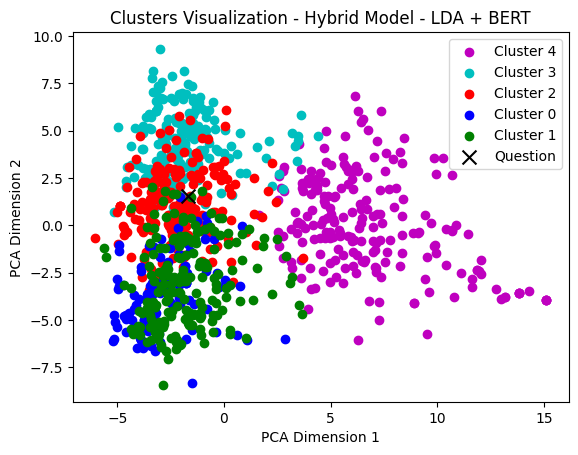

In [100]:
# Combine embeddings for comments and topics
combined_embeddings1 = np.concatenate((comment_topics, comment_embeddings), axis=1)
question_embedding_reshaped = question_embedding.reshape(1, -1)
question_combined1 = np.concatenate((question_topic, question_embedding_reshaped), axis=1)

# Perform dimensionality reduction using PCA
pca_hybrid = PCA(n_components=2, random_state=42)
reduced_embeddings_hybrid = pca_hybrid.fit_transform(combined_embeddings1)

# Define default colors for clusters
default_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot each cluster with default colors
for cluster_label, comments in topics_hybrid1.items():
    cluster_indices = [i for i, label in enumerate(cluster_labels_hybrid1) if label == cluster_label]
    cluster_color = default_colors[cluster_label % len(default_colors)]
    cluster_comments_x = [reduced_embeddings_hybrid[i][0] for i in cluster_indices]
    cluster_comments_y = [reduced_embeddings_hybrid[i][1] for i in cluster_indices]
    plt.scatter(cluster_comments_x, cluster_comments_y, color=cluster_color, label=f'Cluster {cluster_label}')

# Plot the question
question_embedding_reduced = pca_hybrid.transform(question_combined1)
plt.scatter(question_embedding_reduced[0][0], question_embedding_reduced[0][1], color='black', label='Question', marker='x', s=100)

# Add legend and labels
plt.legend()
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Clusters Visualization - Hybrid Model - LDA + BERT')

# Show plot
plt.show()

- LDA + Bert(Quora)

In [101]:
filtered_data = {key: value[:4] for key, value in topics_hybrid2.items()}
pd.DataFrame(filtered_data)

,3,2,0,4,1
0,in order for me is naturalwhiteblackblue the n...,blue i have blue bought my wife the natural on...,black definitely,1 and 3,to me the black phones make the bezels look la...
1,i ordered black titanium not received it yet b...,this is true i almost got one in natural for t...,honestly i wouldnt fault anyone for choosing a...,batman,so let me understand the paint or whatever on ...
2,definitely not the natural titanium everyone s...,i got the white one i tend to go to with white...,i got black because thats the only color they ...,ditz is away,you can barely see fingerprints on it and any ...
3,theres something about the white and natural t...,i got the blue and i love the look but i did a...,1 natural 2 black 3 blue 4 white,thank you for your donation,press on the back glass with your thumbs then ...


In [102]:
relevance_scores_h2 = calculate_relevance_scores(question1df,question_combined2,cluster_embeddings_h2,topics_hybrid2,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_h2)

Relevance Scores for Each Cluster: {3: 1.0, 2: 0.7884593376142386, 0: 0.6944928810939822, 4: 0.0, 1: 0.9203734957925688}


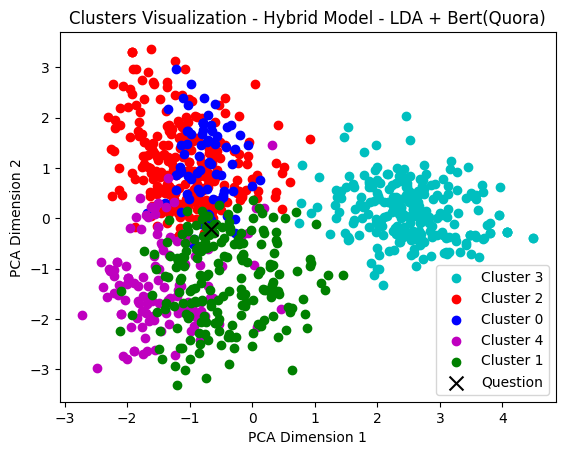

In [103]:
# Combine embeddings for comments and the third set
combined_embeddings2 = np.concatenate((comment_topics, comment_embeddings_m2), axis=1)
question_embedding_reshaped2 = question_embedding_m2.reshape(1, -1)
question_combined2 = np.concatenate((question_topic, question_embedding_reshaped2), axis=1)

# Perform dimensionality reduction using PCA
pca_hybrid2 = PCA(n_components=2, random_state=42)
reduced_embeddings_hybrid2 = pca_hybrid2.fit_transform(combined_embeddings2)

# Define default colors for clusters
default_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot each cluster with default colors
for cluster_label, comments in topics_hybrid2.items():
    cluster_indices = [i for i, label in enumerate(cluster_labels_hybrid2) if label == cluster_label]
    cluster_color = default_colors[cluster_label % len(default_colors)] 
    cluster_comments_x = [reduced_embeddings_hybrid2[i][0] for i in cluster_indices]
    cluster_comments_y = [reduced_embeddings_hybrid2[i][1] for i in cluster_indices]
    plt.scatter(cluster_comments_x, cluster_comments_y, color=cluster_color, label=f'Cluster {cluster_label}')

# Plot the question
question_embedding_reduced2 = pca_hybrid2.transform(question_combined2)
plt.scatter(question_embedding_reduced2[0][0], question_embedding_reduced2[0][1], color='black', label='Question', marker='x', s=100)

# Add legend and labels
plt.legend()
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Clusters Visualization - Hybrid Model - LDA + Bert(Quora)')

# Show plot
plt.show()

- LDA + MiniLM

In [104]:
filtered_data = {key: value[:4] for key, value in topics_hybrid3.items()}
pd.DataFrame(filtered_data)

,2,1,3,0,4
0,in order for me is naturalwhiteblackblue the n...,blue i have blue bought my wife the natural on...,black definitely,1 and 3,to me the black phones make the bezels look la...
1,i ordered black titanium not received it yet b...,this is true i almost got one in natural for t...,honestly i wouldnt fault anyone for choosing a...,that blue smilingfacewithhearteyes,so let me understand the paint or whatever on ...
2,definitely not the natural titanium everyone s...,i got the white one i tend to go to with white...,i got black because thats the only color they ...,batman,you can barely see fingerprints on it and any ...
3,theres something about the white and natural t...,i got the blue and i love the look but i did a...,1 natural 2 black 3 blue 4 white,ditz is away,press on the back glass with your thumbs then ...


In [105]:
relevance_scores_h3 = calculate_relevance_scores(question1df,question_combined3,cluster_embeddings_h3,topics_hybrid3,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_h3)

Relevance Scores for Each Cluster: {2: 1.0, 1: 0.6485419306679798, 3: 0.3249707490111305, 0: 0.0, 4: 0.549980451262985}


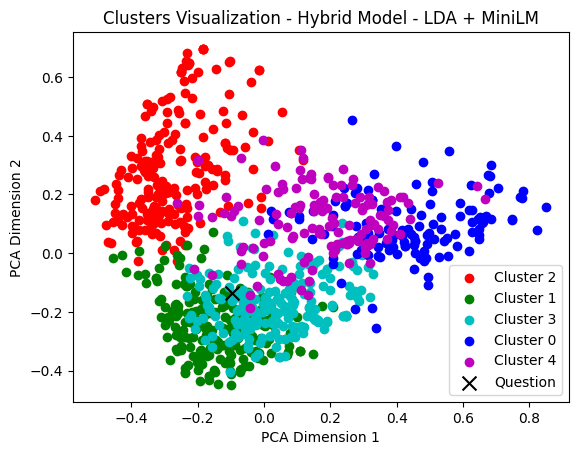

In [106]:
# Combine embeddings for comments and the third set
combined_embeddings3 = np.concatenate((comment_topics, comment_embeddings_m3), axis=1)
question_embedding_reshaped3 = question_embedding_m3.reshape(1, -1)
question_combined3 = np.concatenate((question_topic, question_embedding_reshaped3), axis=1)

# Perform dimensionality reduction using PCA
pca_hybrid3 = PCA(n_components=2, random_state=42)
reduced_embeddings_hybrid3 = pca_hybrid3.fit_transform(combined_embeddings3)

# Define default colors for clusters
default_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot each cluster with default colors
for cluster_label, comments in topics_hybrid3.items():
    cluster_indices = [i for i, label in enumerate(cluster_labels_hybrid3) if label == cluster_label]
    cluster_color = default_colors[cluster_label % len(default_colors)]
    cluster_comments_x = [reduced_embeddings_hybrid3[i][0] for i in cluster_indices]
    cluster_comments_y = [reduced_embeddings_hybrid3[i][1] for i in cluster_indices]
    plt.scatter(cluster_comments_x, cluster_comments_y, color=cluster_color, label=f'Cluster {cluster_label}')

# Plot the question
question_embedding_reduced3 = pca_hybrid3.transform(question_combined3)
plt.scatter(question_embedding_reduced3[0][0], question_embedding_reduced3[0][1], color='black', label='Question', marker='x', s=100)

# Add legend and labels
plt.legend()
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('Clusters Visualization - Hybrid Model - LDA + MiniLM')

# Show plot
plt.show()

**Part 8 : Using all the questions**

Using the model - LDA + MiniLM (kmeans_hybrid3)

In [146]:
questions_list = df['question'].unique()

In [147]:
def get_QnC_embeddings(question,comments):
    #1. Vectorize the corpus using TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform([question] + comments)
    
    #2. Apply Latent Dirichlet Allocation (LDA) for topic modeling
    lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
    lda_model.fit(X)
    
    #3. Transform question and comments to topic distributions (Embeddings using LDA)
    question_topic = lda_model.transform(vectorizer.transform([question]))
    comment_topics = lda_model.transform(vectorizer.transform(comments))

    #4. MiniLm embeddings
    model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu') 
    comment_embeddings = model.encode(comments)
    question_embedding = model.encode(question)

    #5. Concatenate embeddings
    combined_embeddings = np.concatenate((comment_topics, comment_embeddings), axis=1)
    question_embedding_reshaped = question_embedding.reshape(1, -1)
    question_combined = np.concatenate((question_topic, question_embedding_reshaped), axis=1)

    return (question_combined,combined_embeddings)

In [148]:
def get_final_results(question_embedding,comment_embeddings,cluster_labels_hybrid3,df_temp):
    topics = {}
    for i, comment in enumerate(comments):
        if cluster_labels_hybrid3[i] not in topics:
            topics[cluster_labels_hybrid3[i]] = []
        topics[cluster_labels_hybrid3[i]].append(comment)
        
    cluster_embeddings = defaultdict(list)
    for i, comment_embedding in enumerate(comment_embeddings):
        cluster_label = cluster_labels_hybrid3[i]
        cluster_embeddings[cluster_label].append(comment_embedding)
    cluster_embeddings = dict(cluster_embeddings)
    relevance_scores = calculate_relevance_scores(df_temp,question_embedding,cluster_embeddings,topics,'lda')
    return list((topics,relevance_scores))
    

In [149]:
final_results = defaultdict(list)
for i in questions_list:
    df_temp = df[df['question'] == i]
    question = question1df['question'][0]
    comments = question1df['comment'].to_numpy(dtype='object')
    question_embedding,comment_embeddings = get_QnC_embeddings(question,comments)

    kmeans_hybrid3 = KMeans(n_clusters=num_topics)
    kmeans_hybrid3.fit(comment_embeddings)
    cluster_labels_hybrid3 = kmeans_hybrid3.labels_

    results = get_final_results(question_embedding,comment_embeddings,cluster_labels_hybrid3,df_temp)
    final_results[i].append(results)
final_results = dict(final_results)    

In [158]:
final_results[random.choice(questions_list)]

[[{3: ['in order for me is naturalwhiteblackblue the natural and the white will show any scratching a lot less than black and blue when black and blue scratch its just going to show the natural titanium color underneath it so it stands out a lot more',
    'i ordered black titanium not received it yet but i think i may have fucked up',
    'definitely not the natural titanium everyone should stay away from that one especially on the 256gb pro possibly even the 512gb',
    'theres something about the white and natural titanium that is really really classic i also like this gens pink',
    'i got black but kind of wishing i got titanium black is definitely going to age like shit once the titanium scratches and shows raw titanium color under going to go look at the colors at the store tomorrow',
    'got the blue and love it been waiting for this color for a long time and titanium no less',
    'same i also wanted white titanium cuz im leaning towards it lmaoskull',
    'white titanium',


In [173]:
def present_results(key,final_results):
    clusters,relevance_scores = final_results[key][0]
    sorted_scores = dict(sorted(relevance_scores.items(), key=lambda item: item, reverse=True))
    rating = 5
    for i in sorted_scores.keys():
        print("Rating ",rating)
        print("--"*60)
        comments = clusters[i]
        print(comments)
        print("--"*25)
        rating -= 1

In [174]:
present_results(random.choice(questions_list),final_results)

Rating  5
------------------------------------------------------------------------------------------------------------------------
['to me the black phones make the bezels look larger than they are while the silver borders are more immersive', 'so let me understand the paint or whatever on the iphones is not anodized and can scratch off', 'you can barely see fingerprints on it and any haloing around the buttons is extremely subtle', 'press on the back glass with your thumbs then find out', 'if you put a case on it just eenie meenie miney mo that shit', 'happy to help why not just get the previous gen pro i have the 14 pro max and the pictures are wonderful its more scratchdrop resistant and its cheaper it just doesnt have a usb c which is fine given i dont have many chargers for it anyways heres a link on the discoloration id also be worried about them optimizing the phone in the future and if other apps are going to be fixed as it sounds like some arent being optimized for the new chi